In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from contextily import add_basemap
from rasterio import transform, windows
from rasterio.features import rasterize

In [32]:
# Parameter

# Indonesia regencies and cities dataset
INDONESIA_ADMIN_LEVEL_2 = (
    "https://storage.googleapis.com/gee-ramiqcom-bucket/admin/indonesia_adm_level_2.fgb"
)

# Land cover in year 2000
LANDCOVER_2000 = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/forestasi_indonesia/cog/lc_klhk/lc_2000.tif"

# Land cover in year 2021
LANDCOVER_2021 = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/forestasi_indonesia/cog/lc_klhk/lc_2021.tif"

# To filter region of interest in admin data with bounding box
BBOX = (103, -3, 104, -2)

# Name of the province to filter the region of interest
ADMIN_NAME = "Batanghari"  # In Jambi

In [33]:
# Load the region of interest around the BBOX
roi_df = gpd.read_file(INDONESIA_ADMIN_LEVEL_2, bbox=BBOX)
roi_df

,WADMKK,WADMPR,geometry
0,Muaro Jambi,Jambi,"MULTIPOLYGON Z (((103.44663 -2.13437 0, 103.44..."
1,Sarolangun,Jambi,"MULTIPOLYGON Z (((102.2603 -2.62818 0, 102.264..."
2,Batanghari,Jambi,"MULTIPOLYGON Z (((102.9798 -1.94358 0, 102.983..."
3,Musi Rawas,Sumatera Selatan,"MULTIPOLYGON Z (((102.80889 -3.22465 0, 102.81..."
4,Musi Rawas Utara,Sumatera Selatan,"MULTIPOLYGON Z (((102.58577 -3.07014 0, 102.58..."
5,Musi Banyuasin,Sumatera Selatan,"MULTIPOLYGON Z (((103.62294 -3.23999 0, 103.62..."


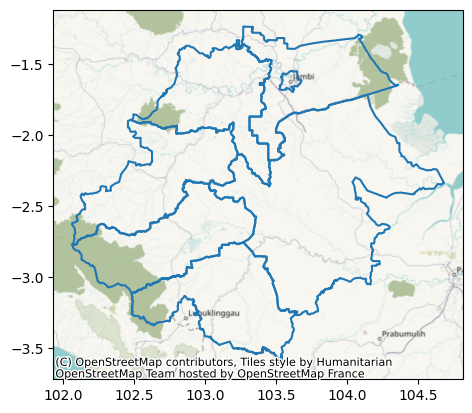

In [34]:
# Plot all of it
ax = roi_df.boundary.plot()
add_basemap(ax, crs="EPSG:4326")

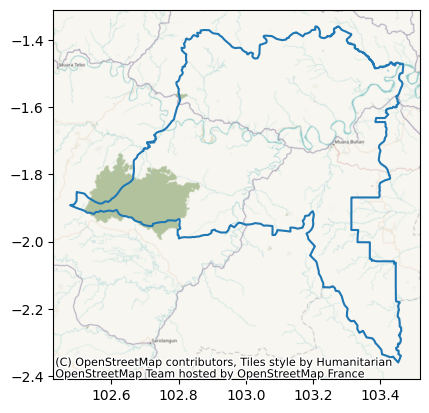

In [35]:
# Select only 1 regency
regency_roi = roi_df[roi_df["WADMKK"] == "Batanghari"]

# Plot it
ax = regency_roi.boundary.plot()
add_basemap(ax, crs="EPSG:4326")

In [36]:
# Geometry parameter to define shape, size, etc
RESOLUTION = 30  # In meter
BOUNDS = tuple(regency_roi.total_bounds)
WIDTH = int(abs(BOUNDS[0] - BOUNDS[2]) * 111_000 / RESOLUTION)
HEIGHT = int(abs(BOUNDS[1] - BOUNDS[3]) * 111_000 / RESOLUTION)
SHAPE = (HEIGHT, WIDTH)
CRS = "EPSG:4326"
TRANSFORM = transform.from_bounds(*BOUNDS, height=HEIGHT, width=WIDTH)
SHAPE

(3699, 3669)

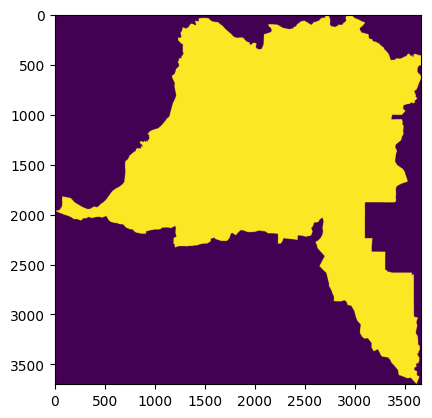

In [37]:
# Convert the ROI into raster for masking the land cover
raster_roi = rasterize(
    [(geo, 1) for geo in regency_roi.geometry],
    fill=0,
    nodata=0,
    out_shape=SHAPE,
    transform=TRANSFORM,
    default_value=1,
    dtype="uint8",
)

# Plot the raster ROI
plt.imshow(raster_roi)

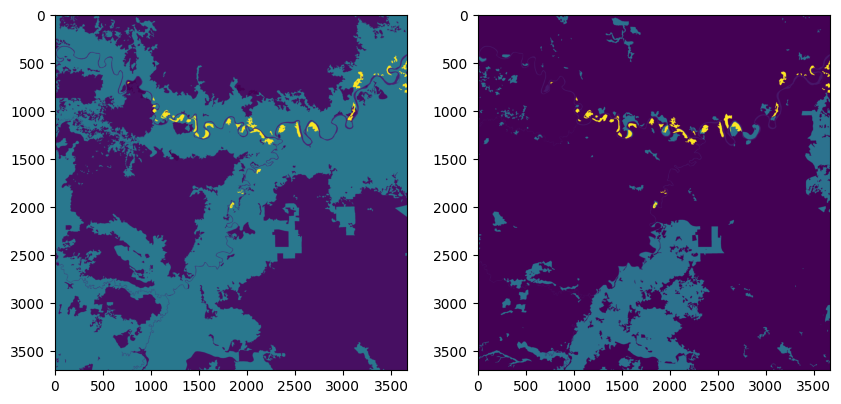

In [38]:
plt.figure(figsize=(10, 5))

# Load the land cover dataset using the bbox of the regency
with rio.open(LANDCOVER_2000) as src:
    window = windows.from_bounds(*BOUNDS, transform=src.transform)
    lc_2000 = src.read(1, out_shape=SHAPE, window=window)
    plt.subplot(1, 2, 1)
    plt.imshow(lc_2000)

with rio.open(LANDCOVER_2021) as src:
    window = windows.from_bounds(*BOUNDS, transform=src.transform)
    lc_2021 = src.read(1, out_shape=SHAPE, window=window)
    plt.subplot(1, 2, 2)
    plt.imshow(lc_2021)
